# 15.6 Zadanie - Hiperparametry

#### Import niezbędnych bibliotek

In [3]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

#### Przygotowanie danych, rozdzielenie ich na zbiory treningowe i testowe

In [5]:
penguins = pd.read_csv('penguins.csv')
num_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'
X = penguins.drop(['Species'], axis=1).copy()
y = penguins['Species'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### Przygotowanie danych numerycznych 

In [7]:
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

#### Transformer dla wartości numerycznych

###### data_preparation = ColumnTransformer(transformers=[

In [10]:
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

#### Tworzenie pipeline dla modelu z hiperparametrami

In [12]:
model_pipeline_hyper = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

#### Określenie parametrów dla grid search

In [14]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [ 0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

#### GridSearch dla znalezienia optymalnych wartości hiperparametrów i wytrenowanie modelu z tymi hipermarametrami

In [16]:
grid_search = GridSearchCV(model_pipeline_hyper, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_hyper = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 16.768329368110066, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.9, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 1}


#### Wizualizacja dla modelu z hiperparametrami oraz oblicznie F1_score dla zbiorów treningowego i testowego

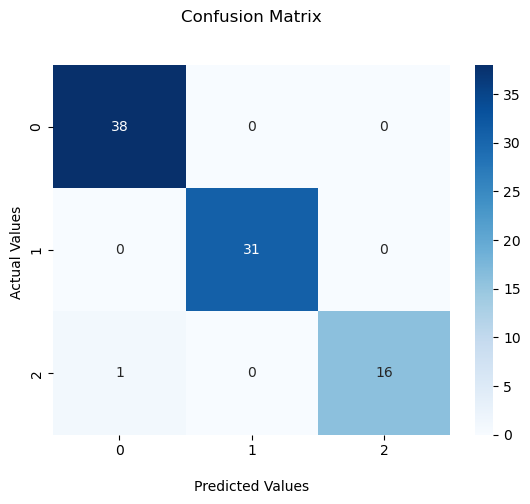

LogisticRegression F1_score Train: 0.9961
LogisticRegression F1_score Test: 0.9884


In [18]:
predictions_test = model_hyper.predict(X_test)
predictions_train = model_hyper.predict(X_train)
cm = confusion_matrix(y_test, predictions_test)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()
print("LogisticRegression F1_score Train:", f1_score(y_train, predictions_train, average='micro').round(4))
print("LogisticRegression F1_score Test:", f1_score(y_test, predictions_test, average='micro').round(4))


#### PODSUMOWANIE - Udało się znaleźć hiperparametry dla naszego modelu i wytrenować go na tych parametrach. Dla wypełniania pustych wpisów wybrano metodę średniej, optymalny stopień wielomianyu to 1, wartość PCA to 0.9, natomiast optymalna wartość model__C to 16.7. Wynik dla zbioru testowego nie poprawił się porównując go do zadania 15.5.